# M7: Logistic Regression
# DAV 6150

- Group Members: Qing Dou, Ruoyu Chen, Zhengnan Li
- Repository: https://github.com/jc000222/Data_Science_DAV6150/tree/main/M7

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')

# 1. Introduction
In this project, we’ve been tasked by a large insurance company with the development of a model that can predict whether or not a given existing customer is likely to purchase an additional insurance product from the company. The insurance company plans to use the output of such a model in an attempt to improve its customer retention and sales practices. Our task for this Assignment is to construct and compare/contrast a series of binary logistic regression 
models that predict whether or not a given insurance company customer is likely to purchase an additional insurance product.

### 1.1 Approach:
- [Introduction](#1-introduction): Import the data set and introduce data variables.  
- [EDA](#2-eda): Explore the raw dataset and do analysis based on domain knowledge.  
- [Data Preparation](#3-Data-Preparation): Perform data cleaning, imputation and transformation.  
- [Prepped Data Overview](#4-Prepped-Data-Overview): Re-run the EDA to ensure the data is well prepared for subsequent modeling.  
- [Regression Modeling](#5-Regression-Modeling): Perform two Poisson, two different negative binomial, two multiple linear regression models and analyse the metrics of the model.  
- [Select Models](#6-Select-Models): Explain how we selected the model selection criteria.  
- [Conclusion](#7-Conclusion)

### 1.2 Data Introduction
The data set is comprised of more than 14,000 observations of 1 response/dependent variable (which indicates whether or not the new insurance product was purchased) and 14 explanatory/independent variables.  
The data set we will be using is sourced from a Kaggle contribution: https://www.kaggle.com/rluyck/insurance-company?select=Customer_data.csv  
Read the data from our github repository. The dataframe is shown below.

In [2]:
customer_raw = pd.read_csv("https://raw.githubusercontent.com/jc000222/Data_Science_DAV6150/main/M7/M7_Data.csv")
customer_raw.head()


,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,Y,99,77,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
1,Y,1,159,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39
2,Y,1,220,42,2,2,1,3,6,1,342.180990,1175.589721,2,42,27
3,Y,99,303,31,2,0,0,0,0,0,453.757916,242.341754,2,31,3
4,Y,99,306,62,2,0,0,0,0,0,384.577469,287.008370,2,62,3


# 2. Exploratory Data Analysis
In this part, we will explore the raw dataset and analyze the missing and invalid values, make histograms and other graphs to determine how to clean the data to improve its usability.  
First start with the matrix of the dataframe. The dataframe has 14016 rows of observations and 15 attributes. We will dive deeper into the dataframe by looking at different columns.

In [3]:
customer_raw.shape

(14016, 15)

Before starting, we define the functions to be used for EDA.

In [4]:
sns.set(style="whitegrid")
def hist(attributes):
    
    if len(attributes) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.histplot(data=customer_raw[attributes[0]], ax=axes)
        axes.set_xlabel(attributes[0])
        axes.set_ylabel('')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(attributes), figsize=(len(attributes)*4, 5))
        for i in range(len(attributes)):
            sns.histplot(ax=axes[i], data=customer_raw[attributes[i]])
            axes[i].set_xlabel(attributes[i])
            axes[i].set_ylabel('')
    plt.show()
def box(attributes):
    if len(attributes) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.boxplot(data=customer_raw[attributes[0]], ax=axes)
        axes.set_xlabel(attributes[0])
        axes.set_ylabel('')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(attributes), figsize=(len(attributes)*4, 5))
        for i in range(len(attributes)):
            sns.boxplot(ax=axes[i], data=customer_raw[attributes[i]])
            axes[i].set_xlabel(attributes[i])
            axes[i].set_ylabel('')
    plt.show()
def bar(attributes):
    if len(attributes) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.countplot(x=customer_raw[attributes[0]], ax=axes)
        axes.set_xlabel(attributes[0])
        axes.set_ylabel('')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(attributes), figsize=(len(attributes)*4, 5))
        for i in range(len(attributes)):
            sns.countplot(ax=axes[i], x=customer_raw[attributes[i]])
            axes[i].set_xlabel(attributes[i])
            axes[i].set_ylabel('')
    plt.show() 
def scatter(attributes):
    if len(attributes) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.scatterplot(x=customer_raw[attributes[0]],y=customer_raw["TARGET"], ax=axes)
        axes.set_xlabel(attributes[0])
        axes.set_ylabel('shares')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(attributes), figsize=(len(attributes)*4, 5))
        for i in range(len(attributes)):
            sns.scatterplot(ax=axes[i], x=customer_raw[attributes[i]],y=customer_raw["TARGET"],alpha=0.1)
            axes[i].set_xlabel(attributes[i])
            axes[i].set_ylabel('')
            axes[0].set_ylabel('shares')
    plt.show()

| Variables   | Definition  | Data type  | Distribution | Correlation | Explanation  |
|------------------------------|-------------------------------------------------|------------|--------------|-------------|-----------------|
| TARGET      | Indicator of buying the new product (0 = no, 1= yes) | Categorical | Biased  |    NA       | This variable is the response variable.                                    |

This coulumn is the response variable and have the value as "Y" and "N" instead of 1 and 0, thus needs transformation.  
From the barplot below we can tell the data is slightly biased, having "N" for 8000 and "Y" for 6000.

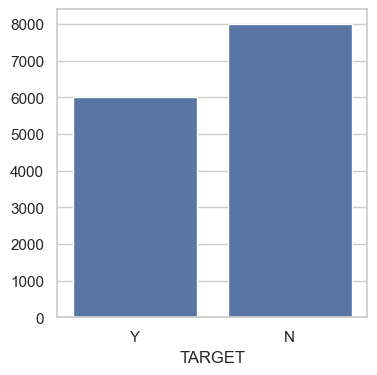

In [5]:
bar(["TARGET"])

| Variables   | Definition  | Data type  | Distribution | Correlation | Explanation  |
|------------------------------|-------------------------------------------------|------------|--------------|-------------|-----------------|
| ID      | Unique customer identifier | NA | NA  |    NA       | This variable is the id of customer.                                    |
| Contract| Type of contract| NA | NA  |    NA       | This variable is contract type of customer.                                   |


ID is the unique identifier for each customer, thus can be dropped.  
Contract only have one unique value 2, thus can be dropped. 

In [6]:
customer_raw["contract"].unique()

array([2], dtype=int64)

### Categorical Variables:

| Variables   | Definition  | Data type  | Correlation | Explanation  |
|------------------------------|-------------------------------------------------|---------------|-------------|-----------------|
| Loyalty      | Loyalty level, from low to high (0 to 3), 99 = unclassified | Ordinal |   NA     | This variable needs to set the unclassified number 99 to null.  |
| City      | Unique code per city |  Non-ordinal   |    NA       | This variable needs to set the unclassified number -999999 to null. This variable has 64 different city code. |
| Type_A      | Type of product A |  Non-ordinal    |    NA       | This variable is the type of product A customer is using. There are 2 types of product A. 0 indicates never bought product A. |
| Type_B      | Type of product B |  Non-ordinal    |    NA       | This variable is the type of product B customer is using. There are 3 types of product B. 0 indicates never bought product B.|
| Prod_A      | Bought Product A (0=no, 1=yes) | Binary |    NA       | This indicates whether bought the product A or not.                            |
| Prod_B      | Bought Product B (0=no, 1=yes) | Binary |    NA       | This indicates whether bought the product A or not.                            |

Variable Prod_A, Prod_B are bound with Type_A, Type_B. When Prod_A is 0, Type_A is also 0; When Prod_A is 1, Type_A can be 3 or 6. This indicates these two variables are highly correlated should be dropped either of them during feature selection.  
For variable "city", "type_A", "type_B","prod_A" and "prod_B" we can try to encode them to dummy variables. But in "type_A" and "type_B" 0 indicates never bought the product and needs to be consider seperately.
In scatter plot, no obvious correlation with the response variable can be observed.

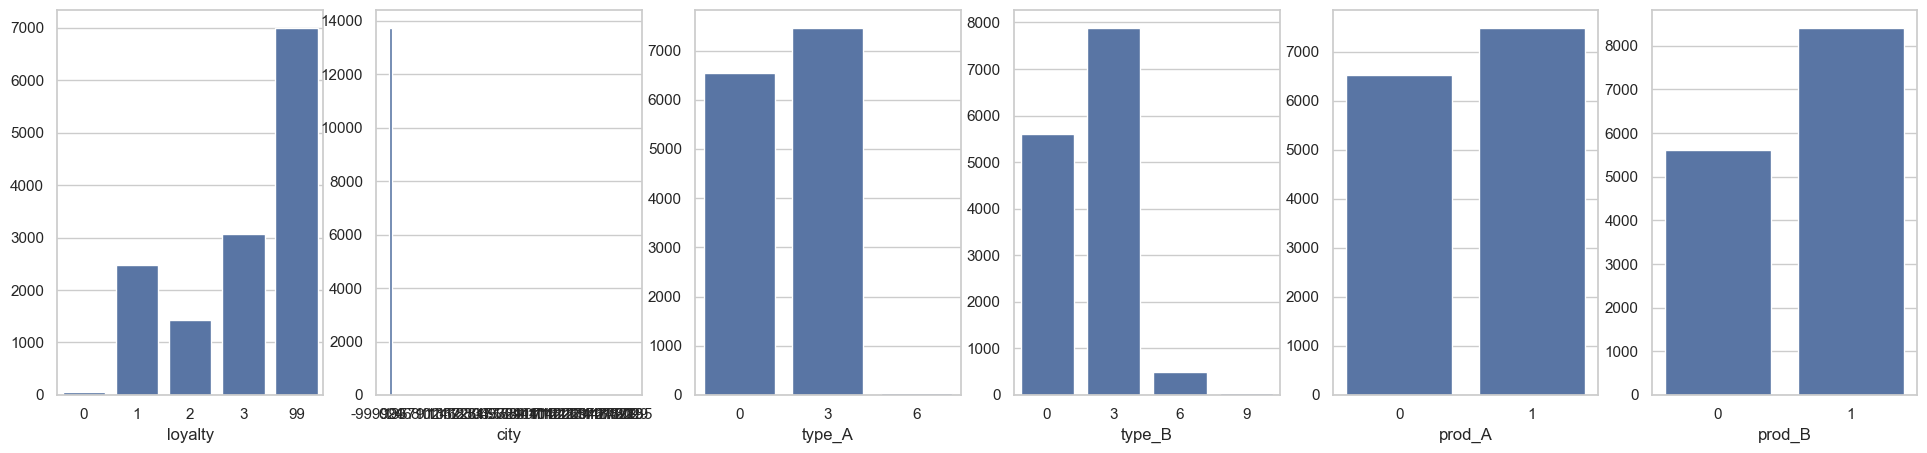

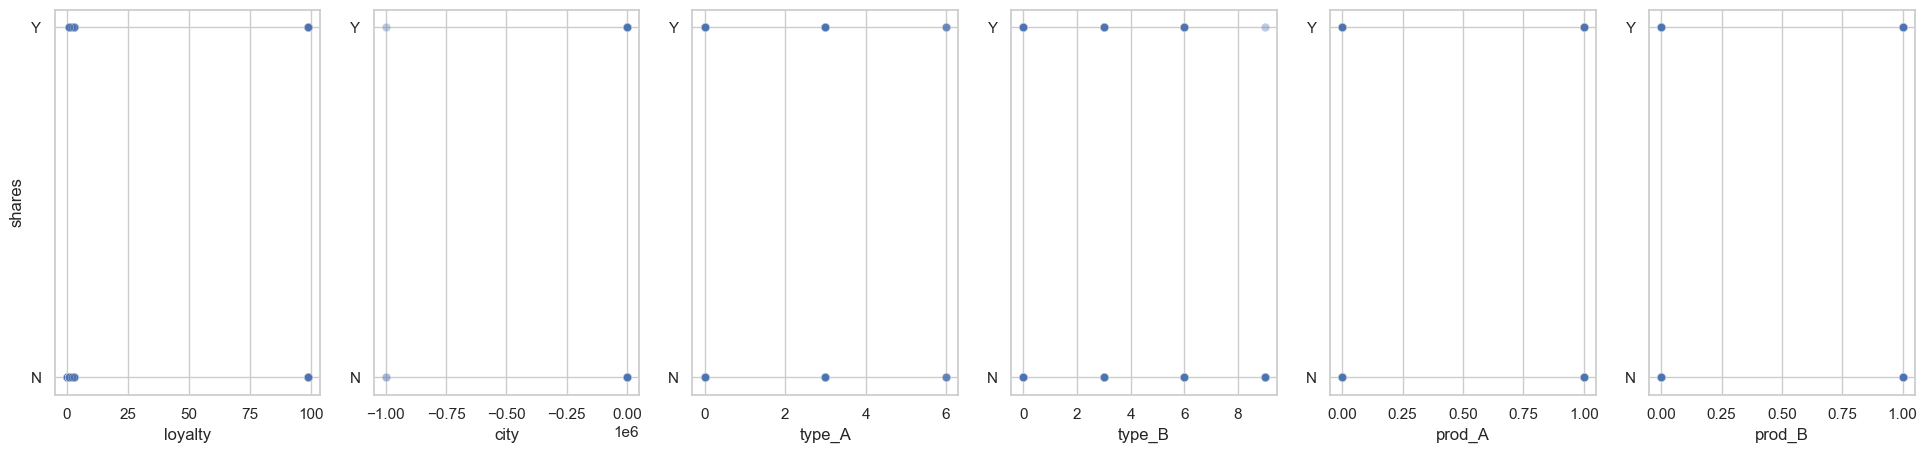

unique codes in city: 64


In [7]:
bar(["loyalty", "city", "type_A", "type_B", "prod_A", "prod_B"])
scatter(["loyalty", "city", "type_A", "type_B", "prod_A", "prod_B"])
print("unique codes in city:",customer_raw[customer_raw["city"] !=-999999]["city"].nunique())


### Numerical  Variables:
| Variables   | Definition  | Distribution | Correlation | Explanation  |
|------------------------------|-------------------------------------------------|---------------|-------------|-----------------|
| Age      | Age in years | Right-Skewed |   NA     | This variable indicates the age of the customer.  |
| Age_p    | Age of partner in years |  Right-Skewed   |    NA       | This variable indicates the age of the partner. |
| LOR      | Length of relationship in years |  Right-Skewed    |    NA       | This variable is the length of relationship in years. |
| LOR_m    | Length of relationship in months |  Right-Skewed    |    NA       | This variable is the length of relationship in months.|
| Turnover_A      | Amount of money spent on Product A | Right-Skewed |    NA       | This indicates the amount of money spent on Product A. Note there are many 0 for the ones who did not buy product A. |
| Turnover_B      | Amount of money spent on Product B | Right-Skewed |    NA       | This indicates the amount of money spent on Product B. Note there are many 0 for the ones who did not buy product B.|

The Age and Age_P is exactly the same, so we can drop one of the variable. Also the LOR and lor_M is very similar, we can drop the LOR.
In scatter plot, no obvious correlation with the response variable can be observed.

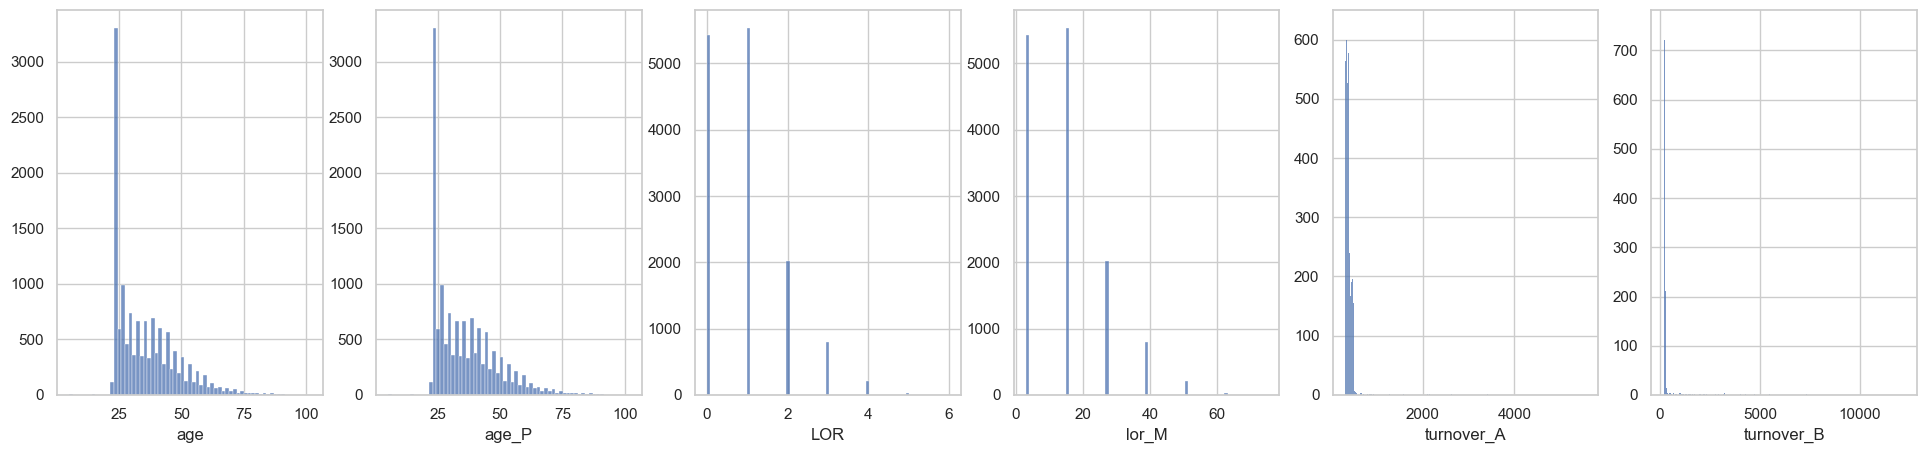

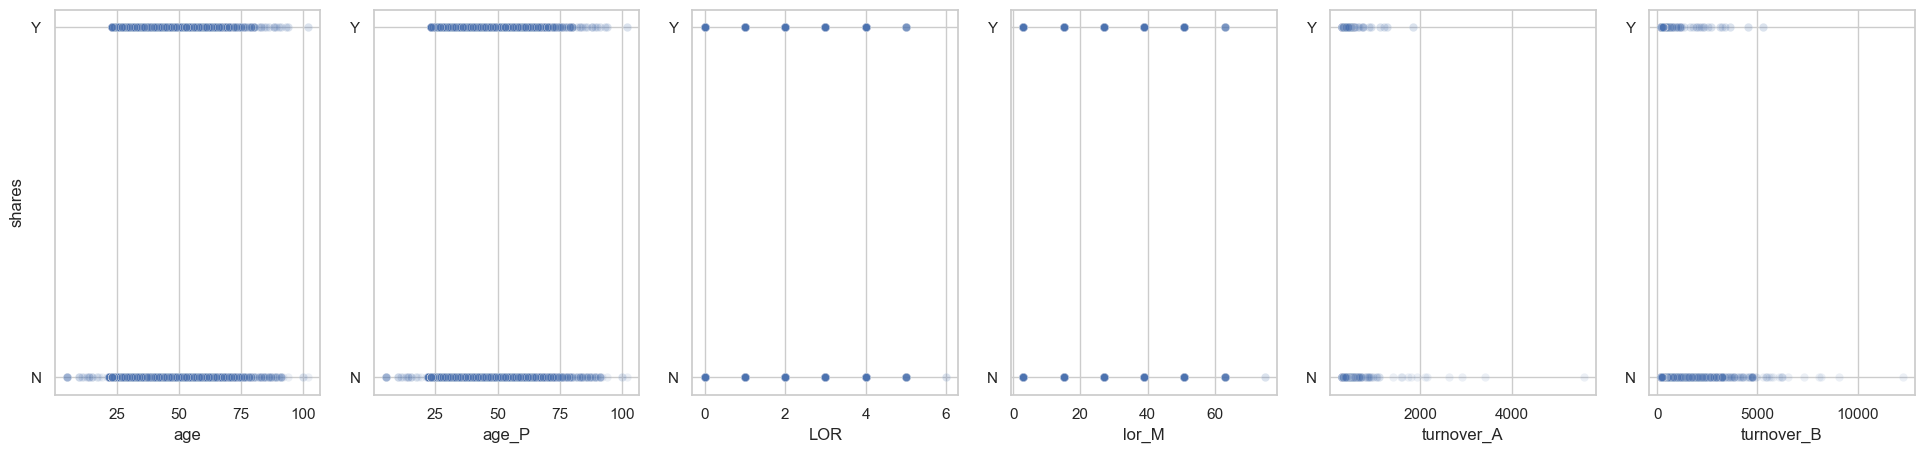

In [8]:
hist(["age", "age_P", "LOR", "lor_M", "turnover_A", "turnover_B"])
scatter(["age", "age_P", "LOR", "lor_M", "turnover_A", "turnover_B"])

## 3. Data Preparation

Describe + show the steps we have taken to address the data integrity +
usability issues we identified in our EDA, including any feature engineering techniques we have
applied to the data set. This section should include any Python code used for Data Preparation.

### 3.1 Data cleaning

There are 3008 rows are duplicated. Drop all the lines that are duplicated.

In [9]:

duplicate_rows = customer_raw.duplicated()
print("duplicate rows:",duplicate_rows.sum())

customer_raw[duplicate_rows]
customer_raw.drop_duplicates(subset=None,keep = 'first',inplace=False)

duplicate rows: 3008


,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,Y,99,77,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
1,Y,1,159,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39
2,Y,1,220,42,2,2,1,3,6,1,342.180990,1175.589721,2,42,27
3,Y,99,303,31,2,0,0,0,0,0,453.757916,242.341754,2,31,3
4,Y,99,306,62,2,0,0,0,0,0,384.577469,287.008370,2,62,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11003,N,1,16793,33,2,2,1,3,3,1,302.380331,229.457986,2,33,27
11004,N,99,16794,23,2,0,0,0,0,0,316.268616,228.518505,2,23,3
11005,N,1,16798,23,2,2,1,3,3,1,385.871241,236.665515,2,23,27
11006,N,99,16800,32,2,1,1,3,3,1,317.578868,226.899614,2,32,15


For the indicaters for unclassified, set them to NULL. 

In [10]:
customer_raw['loyalty'].replace(99, np.nan, inplace=True)
customer_raw['city'].replace(-999999, np.nan, inplace=True)

### 3.2 NULL Check
After setting the unclassified values, we can check the null value distribution. In varaible "loyalty", there are too much null values and we can drop the column during feature selection. For the null values in city, we can simply drop the 10 rows.

TARGET           0
ID               0
age              0
LOR              0
prod_A           0
type_A           0
type_B           0
prod_B           0
turnover_A       0
turnover_B       0
contract         0
age_P            0
lor_M            0
city            10
loyalty       6986
dtype: int64

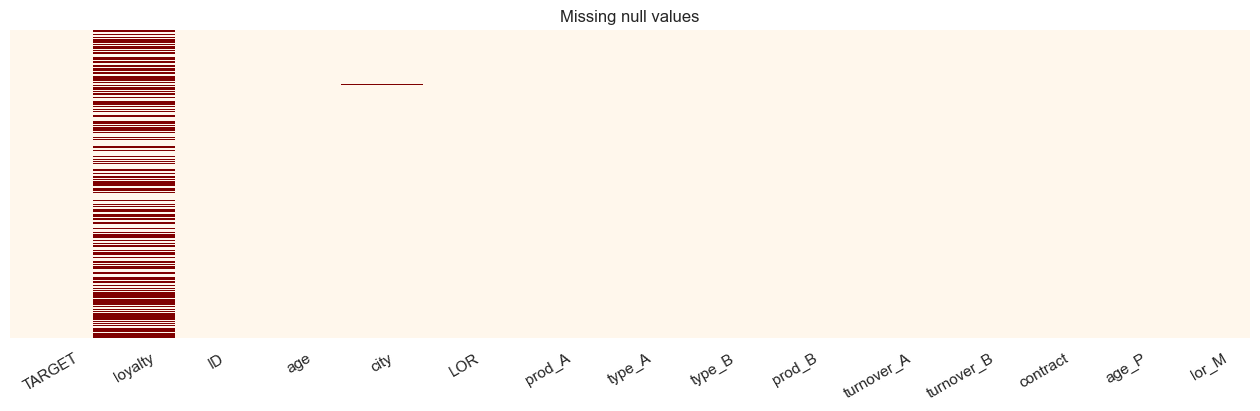

In [11]:
plt.rcParams["figure.figsize"] = (16, 4)
sns.heatmap(customer_raw.isnull(), yticklabels=False, cbar=False, cmap="OrRd")
plt.title("Missing null values")
plt.xticks(rotation=30)
customer_raw.isnull().sum().sort_values()

### 3.3 Column Drop

Through the EDA analysis, we choose to drop contract, age_p, loyalty and ID from the dataframe. Since only 10 null values in city, we can drop the rows. 
When analyzing more than 14,000 rows of data, we found only 300 data where city is not equal to 2. Given the small percentage of these data in the overall dataset, we decided to drop the line where city is not equal to 2. Such processing can help us focus on data where city equals 2, simplifying the analysis process and potentially improving the accuracy and efficiency of the model.

In [12]:
# Delete rows in the 'city' column that contain null values.
customer_cleaned = customer_raw.dropna(subset=["city"])

# Delete rows in the 'city' column that not equal to 2.
df_coustomer = customer_cleaned[customer_cleaned['city'] == 2]

# Remove the column contract, age_p, loyalty and ID from the dataframe
columns_to_drop = ['contract', 'age_P', 'ID','type_A','type_B','loyalty','LOR','city']
df_coustomer = customer_cleaned.drop(columns=columns_to_drop)

### 3.4 Feature Selection

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

__Categorical variable__

First we convert the Response variable ‘target’ to the dummy variable. Then we convert the 'city','loyalty', and merge them with 'prod_A','prod_B' into a new categorical dataframe. We use the SelectKBest function to choose the best 20 categorical features.

In [14]:
# Dummy the Response variable
df_coustomer['TARGET']=pd.get_dummies(df_coustomer['TARGET'], drop_first=True).astype(int)
df_coustomer

,TARGET,age,prod_A,prod_B,turnover_A,turnover_B,lor_M
0,1,66,0,0,333.561114,264.721010,3
1,1,45,1,1,394.735699,284.904978,39
2,1,42,1,1,342.180990,1175.589721,27
3,1,31,0,0,453.757916,242.341754,3
4,1,62,0,0,384.577469,287.008370,3
...,...,...,...,...,...,...,...
14011,1,30,0,0,386.434278,284.309508,3
14012,1,27,1,1,376.842591,266.993794,27
14013,1,26,0,0,434.805703,284.629361,3
14014,1,75,1,1,366.273857,270.573265,15


In [15]:
df_cate=df_coustomer[['prod_A','prod_B']]

__Numerical variable__

First we use MinMaxScaler to scale numerical features to have them in the same range [0, 1] for better model performance.

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Using MinMaxScaler to scale numerical features.
df_num = df_coustomer[['age', 'turnover_A', 'turnover_B','lor_M']]
scaler = MinMaxScaler()

df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns, index=df_num.index)
df_num_scaled

,age,turnover_A,turnover_B,lor_M
0,0.628866,0.006352,0.006034,0.000000
1,0.412371,0.017963,0.007708,0.500000
2,0.381443,0.007988,0.081581,0.333333
3,0.268041,0.029165,0.004178,0.000000
4,0.587629,0.016035,0.007883,0.000000
...,...,...,...,...
14011,0.257732,0.016387,0.007659,0.000000
14012,0.226804,0.014567,0.006223,0.333333
14013,0.216495,0.025568,0.007686,0.000000
14014,0.721649,0.012561,0.006520,0.166667


In [17]:
# Combine feature selected categorical variables and scaled numerical variables
X_final = pd.concat([df_cate, df_num_scaled], axis=1)
y = df_coustomer['TARGET']

# Merge target variables, if needed
df_final = pd.concat([X_final, y], axis=1)
df_final


,prod_A,prod_B,age,turnover_A,turnover_B,lor_M,TARGET
0,0,0,0.628866,0.006352,0.006034,0.000000,1
1,1,1,0.412371,0.017963,0.007708,0.500000,1
2,1,1,0.381443,0.007988,0.081581,0.333333,1
3,0,0,0.268041,0.029165,0.004178,0.000000,1
4,0,0,0.587629,0.016035,0.007883,0.000000,1
...,...,...,...,...,...,...,...
14011,0,0,0.257732,0.016387,0.007659,0.000000,1
14012,1,1,0.226804,0.014567,0.006223,0.333333,1
14013,0,0,0.216495,0.025568,0.007686,0.000000,1
14014,1,1,0.721649,0.012561,0.006520,0.166667,1


## 4. Prepped Data Review 

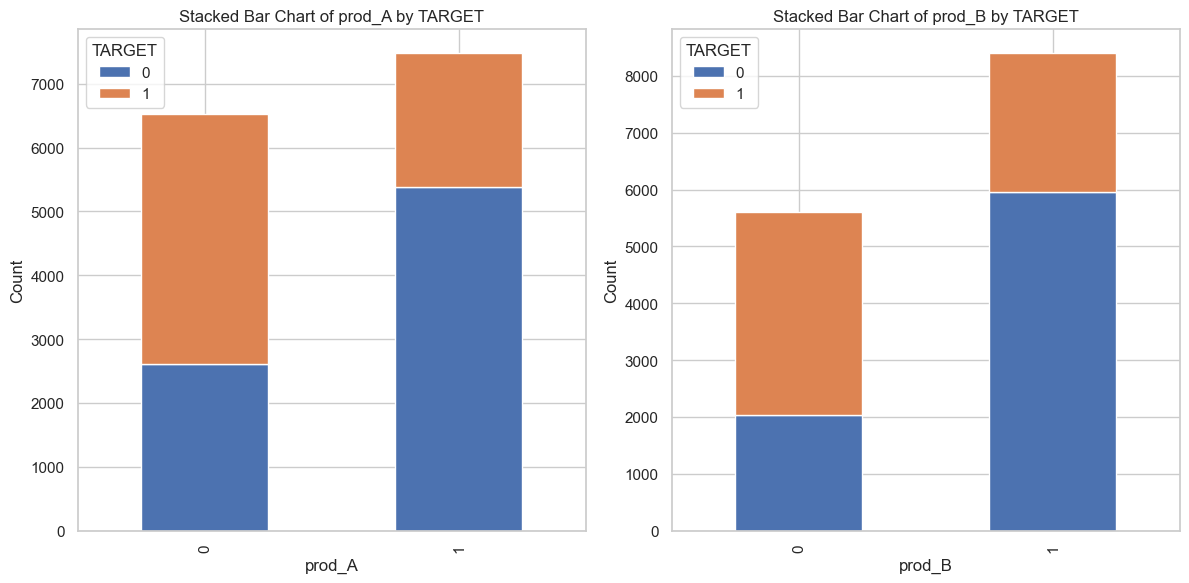

In [18]:
# Compare the response variable with categorcial variables
plt.figure(figsize=(18, 6))

# Loop through each categorical variable
for i, category in enumerate(df_cate, start=1):
    plt.subplot(1, 3, i)
    # Count each category
    grouped = df_coustomer.groupby([category, 'TARGET']).size().unstack(fill_value=0)
    grouped.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f'Stacked Bar Chart of {category} by TARGET')
    plt.xlabel(category)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

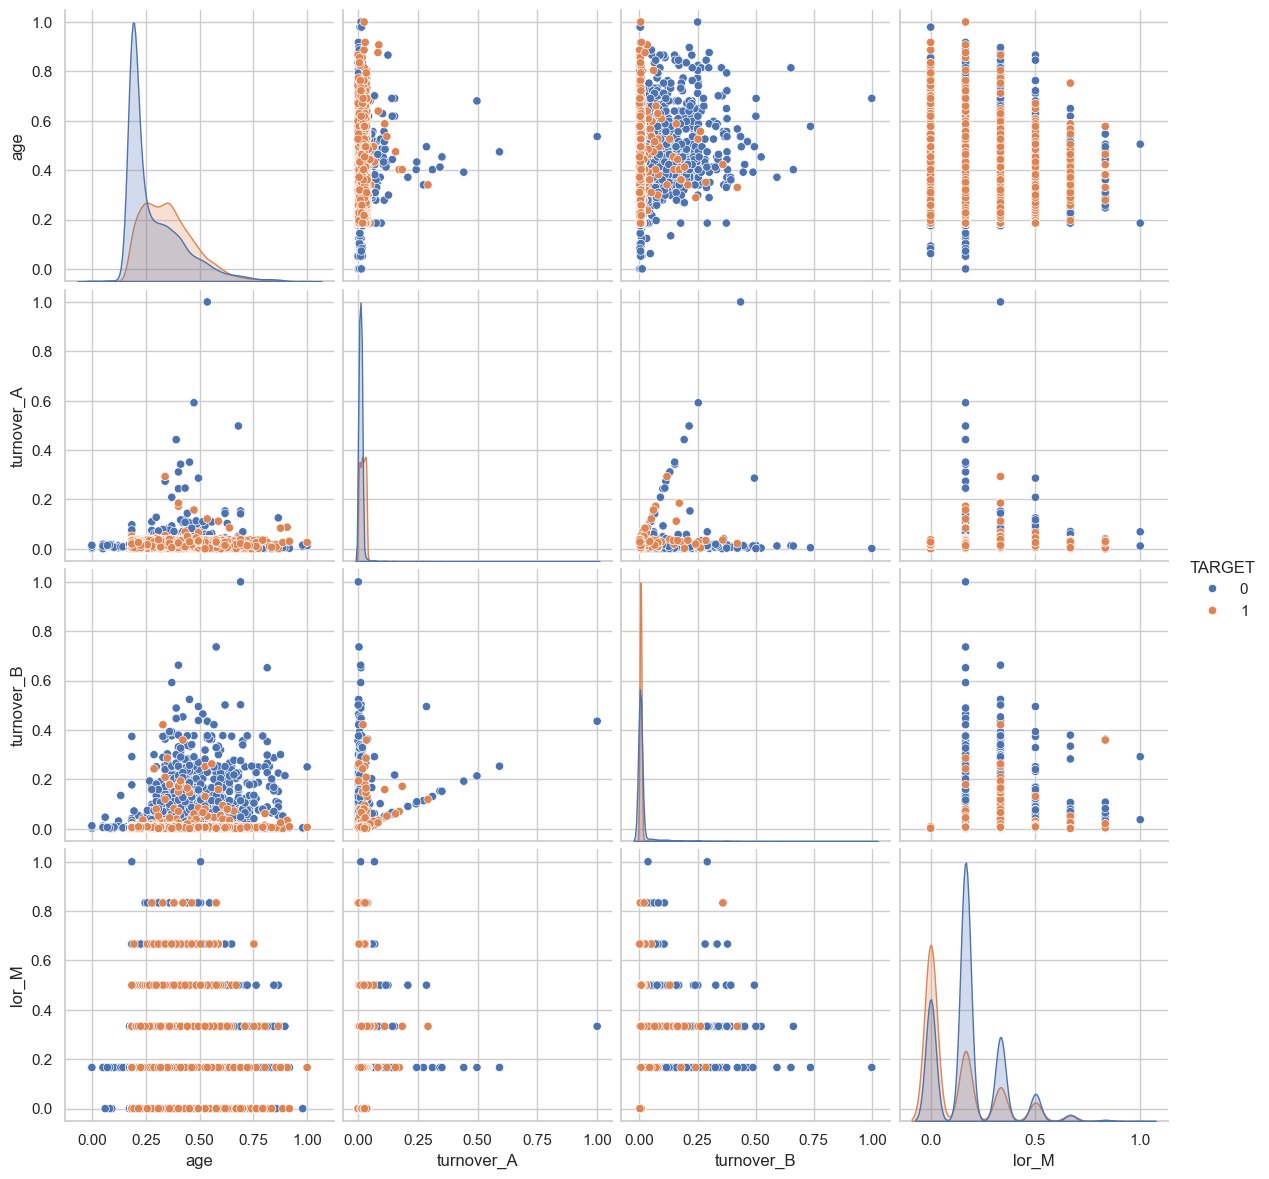

In [28]:
# Compare the response variable with numerical variables
df_num1=df_final[['age','turnover_A','turnover_B','lor_M','TARGET']]
sns.pairplot(df_num1, hue='TARGET',size=3)
plt.show()

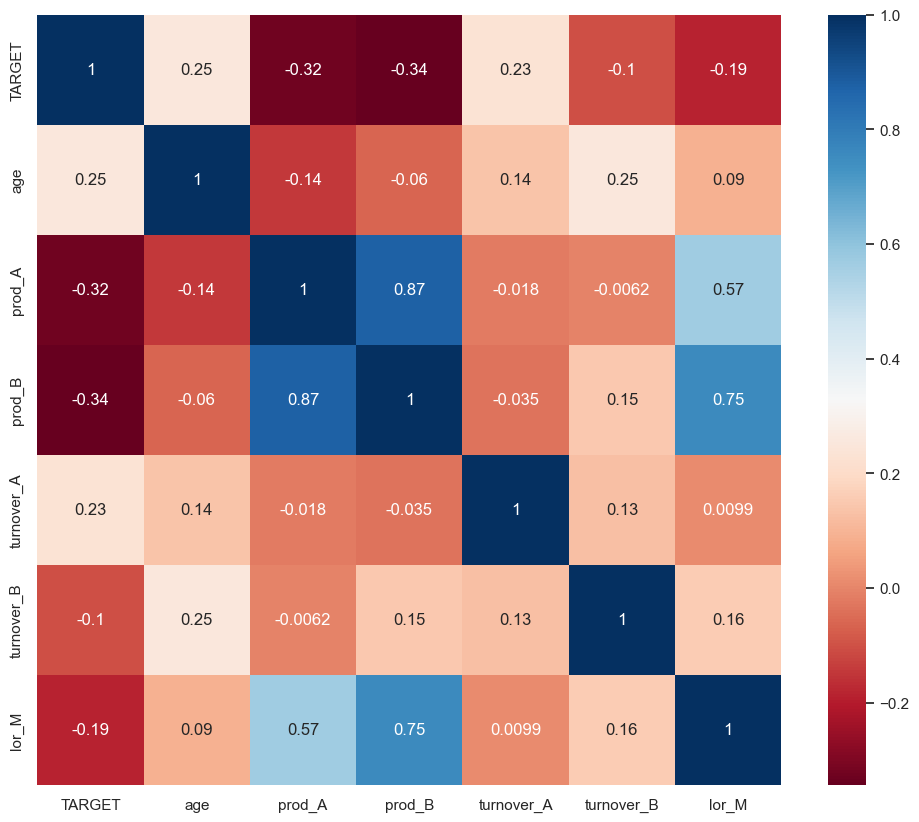

In [20]:
# Use the heatmap to visualize the correlation between each feature
# Finding the correlation bewteen the Features.
plt.figure(figsize=(12,10))
corr = df_coustomer.corr()

# Plot the heatmap
sns.heatmap(corr, cmap="RdBu",xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.show()

## 5. Regression Modeling

In the section, we will use the features which are selected from the eda which used MinMaxScaler to scale numerical features to have them in the same range [0, 1] for better model performance. So, we will try to train our models with different features include categorical variables and numeric variables.Theoretically, we would expect characteristics like age and customer relationship duration to be positively related to the target variable because customers may become more inclined toward certain types of products or services as they age or the customer relationship duration increases.

### Model 1  
Choose numerical variables for model 1.

In [21]:
# Choose numerical variables for model 1
X1 = df_final[['age','turnover_A','turnover_B','lor_M']]
y1 = df_coustomer['TARGET']

# Use the train_test_split function to get the train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.8, random_state=22)

# Perform logistic regression
model1 = LogisticRegression()

# Train the model
model1.fit(X1_train, y1_train)

print(model1.coef_)

[[ 4.04041394  4.63135288 -4.02903248 -2.26518128]]


- 4.04041394: This coefficient corresponds to the age feature. A positive coefficient suggests that as age increases, the log-odds of the target being 1 (assuming 1 is the positive class) also increases.
- 4.63135288: This coefficient is associated with turnover_A. Similarly, a positive coefficient indicates a positive relationship with the target outcome.
- -4.02903248: This coefficient is for turnover_B and is negative, indicating that higher values of turnover_B are associated with a lower probability of the target being 1.
- -2.26518128: This is the coefficient for lor_M, where a negative value suggests a negative relationship with the target variable.

### Model 2  
Choose categorical variables for model 2.

In [22]:
# Choose categorical variables for model 2

X2 = df_cate[['prod_A',	'prod_B']]
y2 = df_coustomer['TARGET']

# Use the train_test_split function to get the train and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.8, random_state=22)

# Perform logistic regression
y_train = y2_train.reset_index(drop = True)
model2 = LogisticRegression()

# Train the model
model2.fit(X2_train, y2_train)

print(model2.coef_)

[[-0.36955616 -1.07380831]]


- -0.36955616: This coefficient is for prod_A and suggests that an increase in this feature is slightly associated with a decrease in the log-odds of the target.
- -1.07380831: This coefficient is for prod_B, with a larger negative value indicating a stronger negative association with the target outcome.

### Model 3  
Combine numerical and categorical variables for model 3.

In [23]:
# Prepare data for model 3
frame = [df_final[['age','turnover_A','turnover_B','lor_M']],df_cate[['prod_A',	'prod_B']]]
df_m3=pd.concat(frame,axis=1)

X3=df_m3
y3 =df_coustomer['TARGET']

# Use the train_test_split function to get the train and test sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.8, random_state=22)

# Perform logistic regression
model3 = LogisticRegression()

# Train the model
model3.fit(X3_train, y3_train)

print(model3.coef_)

[[ 3.44242399  4.36011418 -3.35966413  1.43940149 -0.03669136 -1.68804865]]


- 3.44242399: Coefficient for age, indicating a positive relationship.
- 4.36011418: Coefficient for turnover_A, again indicating a positive relationship.
- -3.35966413: Coefficient for turnover_B, indicating a negative relationship.
- 1.43940149: Coefficient for lor_M, which is positive in this model, differing from the first model, suggesting a positive relationship in this context.
- -0.03669136: Coefficient for prod_A, suggesting a very slight negative relationship with the target.
- -1.68804865: Coefficient for prod_B, indicating a negative relationship with the target outcome.

## 6. Select models
When choosing the best model, We considered several key factors, including the model's accuracy, ability to generalize, and simplicity. Model performance was evaluated using 10-fold cross-validation to ensure the stability and reliability of the evaluation results.

### Model 1

In [24]:
# Evaluate the model 1 using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X1, y1, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[0.70949322 0.69307637 0.7130621  0.71877231 0.70164168 0.70877944
 0.69928571 0.7        0.71928571 0.69642857]
0.7059825124910778


### Model 2

In [25]:
# Evaluate the model 2 using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X2, y2, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[0.6716631  0.66095646 0.67951463 0.67665953 0.6952177  0.68379729
 0.67285714 0.68785714 0.7        0.675     ]
0.6803522993779952


### Model 3

In [26]:
# Evaluate the model 3 using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X3, y3, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[0.70521056 0.70877944 0.72234118 0.72448251 0.74089936 0.72019986
 0.71642857 0.725      0.75142857 0.72      ]
0.723477006220047


After comparing the performance of the three models, we tend to choose __Model 3__ as the preferred model. Model 3 combines numerical features (such as age and turnover) and category features (such as the purchase status of product A and product B), and the accuracy is about 72.35%, which is higher than the model using only numerical features or category features.

Next, Let's see the AUC and ROC to analyze the performance of the model 3.

AUC Score: 0.7756971145760556


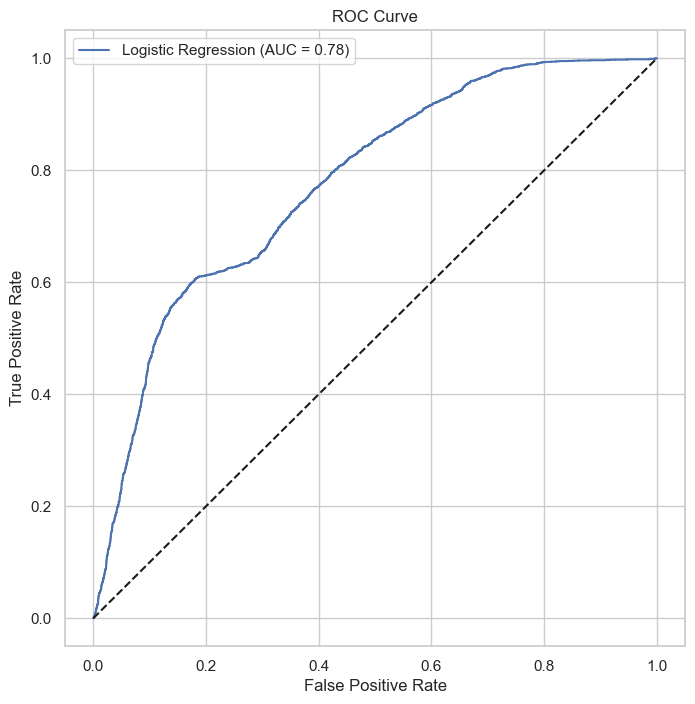

In [29]:
# Predict on the test set
y3_pred = model3.predict(X3_test)
y3_prob = model3.predict_proba(X3_test)[:, 1]  # Get the probability of the positive class

# Calculate AUC score
auc_score = roc_auc_score(y3_test, y3_prob)
print(f'AUC Score: {auc_score}')
plt.figure(figsize=(8, 8))
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y3_test, y3_prob)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

- AUC Score: The AUC score is 0.7757. This value is closer to 1, which means that the model has better ability to distinguish positive and negative categories.
- Roc Curve: The curve has a better curvature in the upper left corner, which shows that at a lower false positive rate, the model is able to achieve a higher true positive rate.

## 7. Conclusions
Our project involved building and evaluating logistic regression models to predict a binary target variable within a customer dataset. The objective was to identify customer characteristics that are indicative of a certain behavior or outcome, which is represented by the target variable. Our project successfully applied logistic regression analysis to understand customer behavior. The iterative process of model building, evaluation, and comparison led to the selection of Model 3 as the preferred predictive model due to its higher accuracy and comprehensive utilization of both numerical and categorical variables.

## Reference
- https://www.cnblogs.com/ljhdo/p/10600702.html
- https://scikit-learn.org/stable/modules/model_evaluation.html